In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

In [3]:
popularity_data = pd.read_csv(r"C:\Users\guyon\OneDrive\Desktop\igdb_data\igdb_data\igdb_popularity_primitives_20250925_1153.csv")
time_to_beat = pd.read_csv(r"C:\Users\guyon\OneDrive\Desktop\igdb_data\igdb_data\igdb_game_time_to_beats_20250925_1112.csv")
games = pd.read_csv(r"C:\Users\guyon\OneDrive\Desktop\igdb_data\igdb_data\igdb_games_20250925_1105.csv")

In [4]:
# Print number of rows in games
print(len(games))

# Count nulls in each column
null_counts = games.isnull().sum()

# Filter only columns with null values
null_df = null_counts[null_counts > 0].reset_index()
null_df.columns = ["column", "null_count"]

# Print the results
print(null_df)

# print(null_df.iloc[[23, 24, 25, 26, 27]])


10000
                     column  null_count
0               age_ratings        2200
1         aggregated_rating        5053
2   aggregated_rating_count        5053
3         alternative_names        3985
4                  artworks        6380
5                   bundles        7666
6                     cover          63
7            external_games          76
8        first_release_date         131
9              game_engines        7856
10               game_modes         290
11                   genres         145
12       involved_companies         257
13                 keywords         790
14        multiplayer_modes        8162
15                platforms          64
16      player_perspectives        1441
17                   rating        2931
18             rating_count        2931
19            release_dates          80
20              screenshots        1352
21            similar_games          54
22                storyline        7575
23                  summary       

In [5]:
# list of columns to drop in games table that have null values and are not needed for analysis
cols_to_drop = ['age_ratings', 'alternative_names', 'artworks', 'bundles', 'cover', 'external_games', 
                'first_release_date', 'game_engines', 'game_modes', 'involved_companies', 'keywords',
                'multiplayer_modes', 'screenshots', 'similar_games', 'storyline', 'summary', 'tags',
                'themes', 'videos', 'websites', 'language_supports', 'collections']
games = games.drop(columns=cols_to_drop)
print(games.columns)

Index(['id', 'aggregated_rating', 'aggregated_rating_count', 'created_at',
       'genres', 'name', 'platforms', 'player_perspectives', 'rating',
       'rating_count', 'release_dates', 'slug', 'total_rating',
       'total_rating_count', 'updated_at', 'url', 'checksum', 'game_type'],
      dtype='object')


In [6]:
# Fill nulls in string columns with 'Unknown'
for col in ['genre', 'platforms', 'player_perspectives']:
    if col in games.columns:
        games[col] = games[col].fillna('Unknown')

# Fill nulls with average for numeric columns
for col in ['aggregated_rating', 'aggregated_rating_count', 'rating', 'rating_count', 'total_rating', 'total_rating_count']:
    if col in games.columns:
        avg_value = games[col].mean()
        games[col] = games[col].fillna(avg_value)

# Convert 'aggregated_rating', 'rating', and 'total_rating' to floats and 1 decimal place
for col in ['aggregated_rating', 'rating', 'total_rating']:
    if col in games.columns:
        games[col] = games[col].astype(float).round(1)

# Fill nulls in 'release_dates' with median date:
# if 'release_dates' in games.columns:
   #  median_date = games['release_dates'].median()
   #  games['release_dates'] = games['release_dates'].fillna(median_date)

In [7]:
# Print number of rows in time_to_beat
print(len(time_to_beat))

# Count nulls in each column
null_counts = time_to_beat.isnull().sum()

# Filter only columns with null values
null_df = null_counts[null_counts > 0].reset_index()
null_df.columns = ["column", "null_count"]

# Print the results
print(null_df)

6092
       column  null_count
0     hastily        3008
1    normally        1288
2  completely        2623


In [8]:
# Fill nulls with average for numeric columns
for col in ['hastily', 'normally', 'completely']:
    if col in time_to_beat.columns:
        avg_value = time_to_beat[col].mean()
        time_to_beat[col] = time_to_beat[col].fillna(avg_value)

In [9]:
# Merging all the tables into one so we can conduct analysis 

merged_df = (
    games
    .merge(time_to_beat, left_on='id', right_on = 'game_id', how='left')
    .merge(popularity_data, left_on='game_id', right_on = 'game_id', how='left')
)

print(merged_df.head())

   id_x  aggregated_rating  aggregated_rating_count  created_at_x   genres  \
0     1               90.0                      1.0    1297556438  5|13|31   
1     1               90.0                      1.0    1297556438  5|13|31   
2     1               90.0                      1.0    1297556438  5|13|31   
3     1               90.0                      1.0    1297556438  5|13|31   
4     1               90.0                      1.0    1297556438  5|13|31   

                      name platforms player_perspectives  rating  \
0  Thief II: The Metal Age         6                   1    87.2   
1  Thief II: The Metal Age         6                   1    87.2   
2  Thief II: The Metal Age         6                   1    87.2   
3  Thief II: The Metal Age         6                   1    87.2   
4  Thief II: The Metal Age         6                   1    87.2   

   rating_count  ...  updated_at_y                            checksum_y  \
0         142.0  ...  1.728557e+09  6a7c09cc-1

In [10]:
# Code for Ratings of the Top 10 Genres based on Time to Beat Mode Graph 



# Choose genre column
genre_col = "genres" if "genres" in merged_df.columns else ("genre" if "genre" in merged_df.columns else None)
if genre_col is None:
    raise KeyError("No 'genres' or 'genre' column in merged_df.")

# Keep columns we need (including total_rating ONLY)
need = [genre_col, "name", "total_rating", "hastily", "normally", "completely"]
work = merged_df[[c for c in need if c in merged_df.columns]].copy()

# Split pipe-delimited genres -> explode
work[genre_col] = work[genre_col].fillna("").astype(str)
work["genre_code_list"] = work[genre_col].str.split("|")
long_genre = work.explode("genre_code_list", ignore_index=True)

# Clean empty codes
long_genre["genre_code_list"] = long_genre["genre_code_list"].str.strip()
long_genre = long_genre[long_genre["genre_code_list"].notna() & (long_genre["genre_code_list"] != "")]

# Map numeric IDs -> genre labels
genre_map = {
    2:"Point-and-click", 4:"Fighting", 5:"Shooter", 7:"Music", 8:"Platform", 9:"Puzzle",
    10:"Racing", 11:"Real Time Strategy (RTS)", 12:"Role-playing (RPG)", 13:"Simulator",
    14:"Sport", 15:"Strategy", 16:"Turn-based strategy (TBS)", 24:"Tactical",
    25:"Hack and slash/Beat 'em up", 26:"Quiz/Trivia", 30:"Pinball", 31:"Adventure",
    32:"Indie", 33:"Arcade"
}
long_genre["genre_id"]    = pd.to_numeric(long_genre["genre_code_list"], errors="coerce")
long_genre["genre_label"] = long_genre["genre_id"].map(genre_map).fillna("Unknown")

# Use ONLY total_rating
if "total_rating" not in long_genre.columns:
    raise KeyError("Column 'total_rating' not found; required for rating.")
long_genre["game_rating"] = pd.to_numeric(long_genre["total_rating"], errors="coerce")

In [11]:
# Cleaning Time-to-beat columns: convert to hours if needed
ttb_cols = [c for c in ["hastily","normally","completely"] if c in long_genre.columns]
for c in ttb_cols:
    long_genre[c] = pd.to_numeric(long_genre[c], errors="coerce")
    med = long_genre[c].dropna().median()
    if pd.notna(med) and med > 300:           # likely seconds
        long_genre[c] = long_genre[c] / 3600  # convert to hours

# Long form by mode
ttb_long = long_genre.melt(
    id_vars=["name","genre_label","game_rating"],
    value_vars=ttb_cols,
    var_name="mode",
    value_name="hours"
)

# Basic cleaning: valid numbers + cap extreme outliers
ttb_long = ttb_long.dropna(subset=["hours","game_rating"])
if len(ttb_long):
    hi = ttb_long["hours"].quantile(0.99)     # 99th percentile cap
    ttb_long = ttb_long[(ttb_long["hours"] > 0) & (ttb_long["hours"] <= hi)]

# Average rating for each genre and mode
agg = (
    ttb_long
      .groupby(["genre_label", "mode"], as_index=False)
      .agg(
          mean_hours=("hours", "mean"),             # x-axis
          mean_rating=("game_rating", "mean"),      # color + labels (this is total_rating from earlier)
          n=("hours", "size")                        # count (optional)
      )
)

# Focus on most common genres
top_genres = (
    agg.groupby("genre_label")["n"].sum()
       .sort_values(ascending=False)
       .head(10)
       .index.tolist()
)
plot_df = agg[agg["genre_label"].isin(top_genres)].copy()

C:\Users\guyon\AppData\Local\Temp\ipykernel_6664\3448508323.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


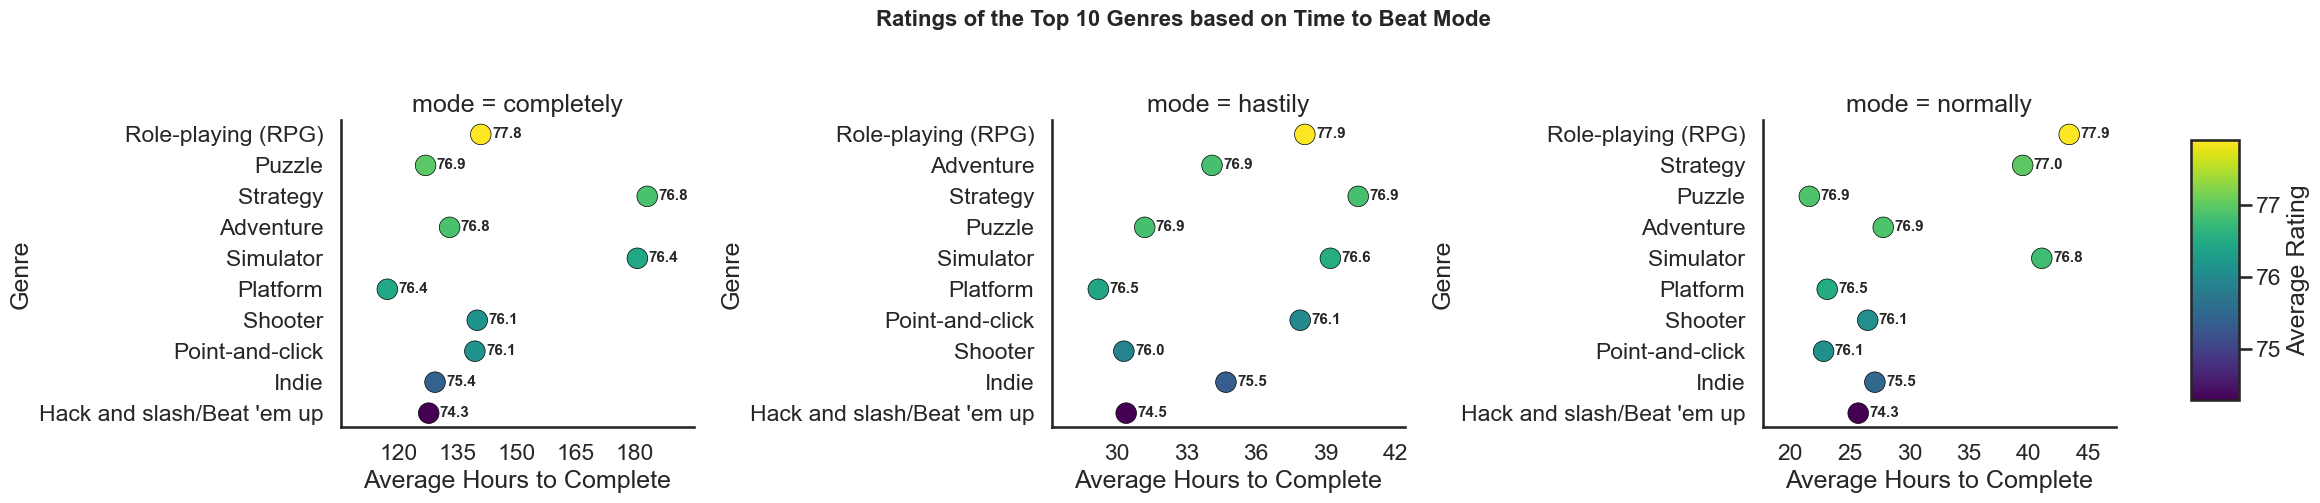

In [12]:
# Creating the Visualization

# --- make a copy and round ONCE at source ---
plot_df = agg[agg["genre_label"].isin(top_genres)].copy()
plot_df["mean_hours_r"]  = np.around(plot_df["mean_hours"].values,  1)
plot_df["mean_rating_r"] = np.around(plot_df["mean_rating"].values, 1)

# Precompute roomy x-limits for each mode (with padding)
pad_ratio = 0.18
xlims = {}
for m, sub in plot_df.groupby("mode"):
    lo = float(sub["mean_hours_r"].min())
    hi = float(sub["mean_hours_r"].max())
    span = max(hi - lo, 1.0)
    pad = max(span * pad_ratio, 1.0)
    xlims[m] = (lo - pad, hi + pad)

# Wider facets (aspect>1) and no shared axes
sns.set_style("white"); sns.set_context("talk")
g = sns.FacetGrid(plot_df, col="mode", col_wrap=3, height=5, aspect=1.6, sharex=False, sharey=False)

def _facet_scatter(data, **kwargs):
    # order genres by (rounded) rating desc for THIS facet
    order = (data.sort_values("mean_rating_r", ascending=False)["genre_label"]
                .drop_duplicates().tolist())
    d = data.copy()
    d["genre_label"] = pd.Categorical(d["genre_label"], categories=order, ordered=True)

    ax = plt.gca()
    sns.scatterplot(
        data=d, x="mean_hours_r", y="genre_label",
        hue="mean_rating_r", palette="viridis", s=220,
        edgecolor="black", linewidth=0.5, legend=False, ax=ax
    )

    # rating labels
    for _, r in d.iterrows():
        ax.annotate(f"{r['mean_rating_r']:.1f}",
                    xy=(r["mean_hours_r"], r["genre_label"]),
                    xytext=(8, 0), textcoords="offset points",
                    va="center", fontsize=11, fontweight="bold")

    # apply roomy x-limits for this mode
    mode_here = d["mode"].iloc[0]
    ax.set_xlim(*xlims.get(mode_here, (None, None)))

    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    sns.despine(ax=ax, top=True, right=True)
    ax.grid(False)
    ax.set_xlabel("Average Hours to Complete")
    ax.set_ylabel("Genre")

g.map_dataframe(_facet_scatter)

# colorbar based on the rounded ratings
vmin = plot_df["mean_rating_r"].min(); vmax = plot_df["mean_rating_r"].max()
norm = plt.Normalize(vmin, vmax); sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm); sm.set_array([])
cbar_ax = g.fig.add_axes([0.92, 0.24, 0.02, 0.52])
g.fig.colorbar(sm, cax=cbar_ax, label="Average Rating")

# extra breathing room for x-labels and facets
g.fig.subplots_adjust(bottom=0.28, wspace=0.38)
g.fig.suptitle("Ratings of the Top 10 Genres based on Time to Beat Mode",
               y=1.02, fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [13]:
# Years with the Highest Rated Games Graph

# Gathering the columns that are needed for the graph
cols = [c for c in ["game_id", "total_rating", "release_dates"] if c in merged_df.columns]
df = merged_df[cols].copy()

# numeric ratings
df["total_rating"] = pd.to_numeric(df["total_rating"], errors="coerce")

# --- Extract release year robustly (datetime first, regex fallback) ---
year_dt = pd.to_datetime(df["release_dates"], errors="coerce").dt.year
year_rx = df["release_dates"].astype(str).str.extract(r"(\d{4})")[0].astype(float)
df["year"] = year_dt.fillna(year_rx)

# keep plausible years only
df.loc[~df["year"].between(1900, 2100, inclusive="both"), "year"] = np.nan

# --- Build decades (e.g., 1987 -> 1980 -> '1980s') ---
df["decade_start"] = (df["year"] // 10) * 10
df["decade"] = df["decade_start"].apply(lambda x: f"{int(x)}s" if pd.notna(x) else np.nan)

# Establishing the decades
order = ["1980s", "1990s", "2000s", "2010s", "2020s"]
df = df[df["decade"].isin(order)].copy()
df["decade"] = pd.Categorical(df["decade"], categories=order, ordered=True)

# --- Aggregate AFTER labeling decades ---
decade_avg = (
    df.groupby("decade", as_index=False)
      .agg(avg_rating=("total_rating", "mean"),
           n=("total_rating", "size"))
      .sort_values("decade")
)

C:\Users\guyon\AppData\Local\Temp\ipykernel_6664\3183081244.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  year_dt = pd.to_datetime(df["release_dates"], errors="coerce").dt.year
C:\Users\guyon\AppData\Local\Temp\ipykernel_6664\3183081244.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("decade", as_index=False)


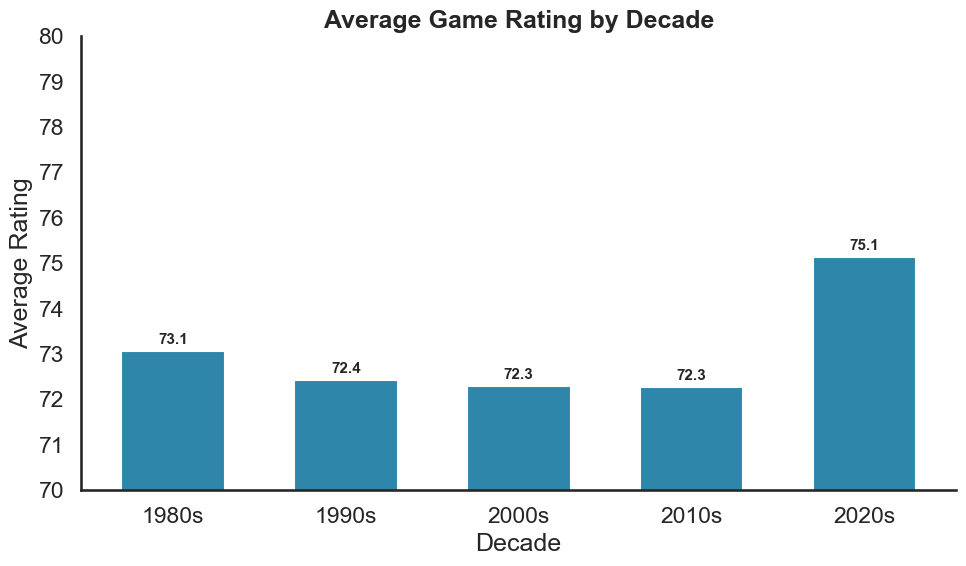

In [14]:
# --- Create Bar Chart ---
sns.set_style("white")
sns.set_context("talk")
BRAND = "#2E86AB"

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(decade_avg["decade"], decade_avg["avg_rating"], color=BRAND, width=0.6)

# Label each bar with value
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:.1f}",
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), textcoords="offset points",
                ha="center", fontsize=11, fontweight="bold")

# clean visuals
sns.despine(ax=ax, top=True, right=True)
ax.grid(False)
ax.set_xlabel("Decade")
ax.set_ylabel("Average Rating")
ax.set_title("Average Game Rating by Decade", fontweight="bold")

# Adjust Y-axis range and ticks
ax.set_ylim(70, 80)
ax.set_yticks(np.arange(70, 81, 1))

plt.tight_layout()
plt.show()

In [15]:
# Platform Popularity Analysis Graph

platform_map = {
    6:"PC (Windows)", 48:"PlayStation 4", 49:"Xbox One", 130:"Nintendo Switch",
    167:"PlayStation 5", 169:"Xbox Series X/S", 9:"PlayStation 3", 12:"Xbox 360",
    20:"Nintendo DS", 41:"Wii", 5:"Wii U", 7:"PlayStation 2", 8:"Xbox",
    3:"Linux", 14:"Mac", 34:"iOS", 21:"Android"
}

# ---- pick columns available and prepare base frame ----
plat_col = "platforms" if "platforms" in merged_df.columns else (
    "platform" if "platform" in merged_df.columns else None
)
if plat_col is None:
    raise KeyError("No 'platforms' or 'platform' column in merged_df.")

modes = [c for c in ["hastily", "normally", "completely"] if c in merged_df.columns]
base_cols = [plat_col, "name", "total_rating"] + modes
df = merged_df[[c for c in base_cols if c in merged_df.columns]].copy()

# ratings numeric
df["total_rating"] = pd.to_numeric(df["total_rating"], errors="coerce")
df = df.dropna(subset=["total_rating"])

# split & explode platform tokens
df[plat_col] = df[plat_col].fillna("").astype(str)
df["platform_code"] = df[plat_col].str.split("|")
df = df.explode("platform_code", ignore_index=True)
df["platform_code"] = df["platform_code"].str.strip()
df = df[df["platform_code"] != ""]

# map to readable labels (fallback to raw token)
df["platform_id"] = pd.to_numeric(df["platform_code"], errors="coerce")
df["platform_label"] = df["platform_id"].map(platform_map).fillna(df["platform_code"])

# ---- Build long data: one row per (platform, game, mode) where that mode exists ----
frames = []
for m in modes:
    sub = df.loc[df[m].notna(), ["platform_label", "total_rating", m]].copy()
    sub = sub.rename(columns={m: "ttb"})
    frames.append(sub.assign(mode=m))
if not frames:
    raise ValueError("No mode columns with data were found.")

long = pd.concat(frames, ignore_index=True)

# convert ttb to numeric hours (heuristic: seconds -> divide by 3600)
long["ttb"] = pd.to_numeric(long["ttb"], errors="coerce")
med = long["ttb"].dropna().median()
if pd.notna(med) and med > 300:
    long["hours"] = long["ttb"] / 3600.0
else:
    long["hours"] = long["ttb"]

# ---- Aggregate: average rating per platform × mode ----
agg = (
    long.groupby(["platform_label", "mode"], as_index=False)
        .agg(mean_hours=("hours", "mean"),
             mean_rating=("total_rating", "mean"),
             n=("hours", "size"))
)

# Keep platforms with the most games to keep the chart readable
top_platforms = (agg.groupby("platform_label")["n"].sum()
                   .sort_values(ascending=False)
                   .head(10).index.tolist())
plot_df = agg[agg["platform_label"].isin(top_platforms)].copy()

# round once to eliminate 0.1 mismatches in labels vs color
plot_df["mean_hours_r"]  = np.around(plot_df["mean_hours"].values,  1)
plot_df["mean_rating_r"] = np.around(plot_df["mean_rating"].values, 1)

C:\Users\guyon\AppData\Local\Temp\ipykernel_6664\2883540396.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


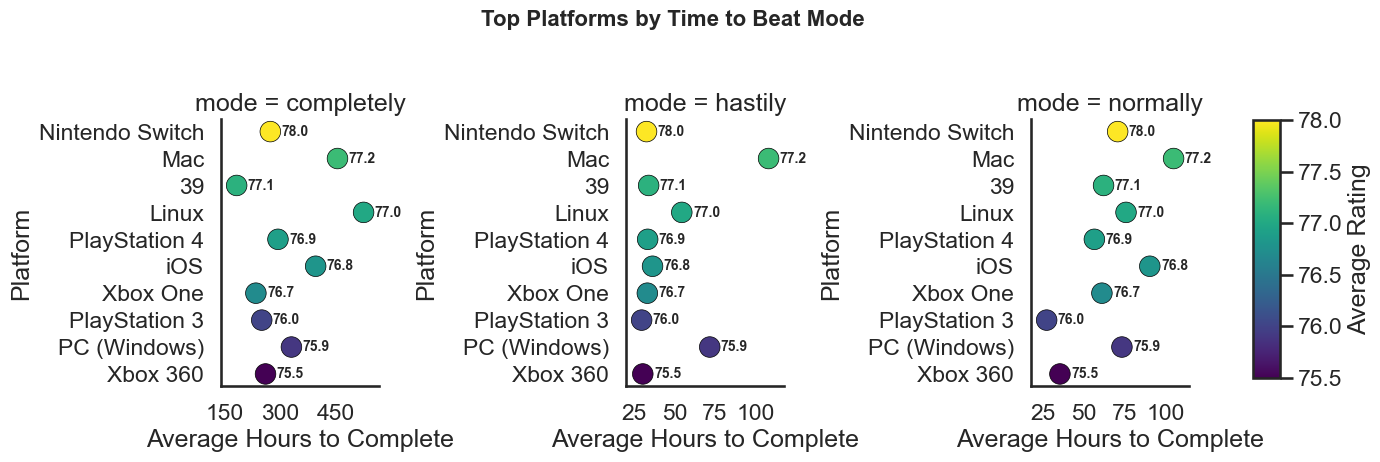

In [16]:
# ---- Plot ----
sns.set_style("white"); sns.set_context("talk")
g = sns.FacetGrid(plot_df, col="mode", col_wrap=3, height=4.6, sharex=False, sharey=False)

def _facet_scatter(data, **kwargs):
    # order platforms by rating (desc) per facet
    order = (data.sort_values("mean_rating_r", ascending=False)["platform_label"]
                .drop_duplicates().tolist())
    d = data.copy()
    d["platform_label"] = pd.Categorical(d["platform_label"], categories=order, ordered=True)

    ax = plt.gca()
    sns.scatterplot(
        data=d, x="mean_hours_r", y="platform_label",
        hue="mean_rating_r", palette="viridis",
        s=220, edgecolor="black", linewidth=0.5, legend=False, ax=ax
    )

    # label each point with the rounded avg rating
    for _, r in d.iterrows():
        ax.annotate(f"{r['mean_rating_r']:.1f}",
                    xy=(r["mean_hours_r"], r["platform_label"]),
                    xytext=(8, 0), textcoords="offset points",
                    va="center", fontsize=10, fontweight="bold")

    # tidy axis
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.margins(x=0.12)
    sns.despine(ax=ax, top=True, right=True)
    ax.grid(False)
    ax.set_xlabel("Average Hours to Complete")
    ax.set_ylabel("Platform")

g.map_dataframe(_facet_scatter)

# shared colorbar for average rating
vmin, vmax = plot_df["mean_rating_r"].min(), plot_df["mean_rating_r"].max()
norm = plt.Normalize(vmin, vmax)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm); sm.set_array([])

cbar_ax = g.fig.add_axes([0.92, 0.22, 0.02, 0.56])
g.fig.colorbar(sm, cax=cbar_ax, label="Average Rating")

g.fig.subplots_adjust(bottom=0.18, wspace=0.35)  # extra space for x-labels
g.fig.suptitle("Top Platforms by Time to Beat Mode", y=1.02, fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()